In [10]:
#from __future__ import print_function;
import nibabel as nb;
import numpy as np;
%matplotlib inline
import matplotlib.pyplot as plt
import cortex;
import os;
import pandas as pd;
import h5py;
import nilearn as nl;
import nilearn.masking as nlmask
import sklearn as sk;
from nibabel.testing import data_path;
from ipywidgets import interact, interactive, fixed, interact_manual, widgets;
from nilearn import datasets;
from sklearn.svm import SVC
import seaborn as sns






In [2]:
hax2 = datasets.fetch_haxby(subjects=6);


Dataset created in /Users/admin/nilearn_data/haxby2001



Downloaded 2969 of 2969 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 408 of 408 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 314803244 of 314803244 bytes (100.0%,    0.0s remaining) ...done. (171 seconds, 2 min)
Extracting data from /Users/admin/nilearn_data/haxby2001/d1443f4ed1a3970a3d45bab61a830819/subj1-2010.01.14.tar.gz..... done.


Downloaded 291168628 of 291168628 bytes (100.0%,    0.0s remaining) ...done. (161 seconds, 2 min)
Extracting data from /Users/admin/nilearn_data/haxby2001/d1443f4ed1a3970a3d45bab61a830819/subj2-2010.01.14.tar.gz..... done.


Downloaded 296936090 of 296936090 bytes (100.0%,    0.0s remaining) ...done. (135 seconds, 2 min)
Extracting data from /Users/admin/nilearn_data/haxby2001/d1443f4ed1a3970a3d45bab61a830819/subj3-2010.01.14.tar.gz..... done.


Downloaded 329954386 of 329954386 bytes (100.0%,    0.0s remaining) ...done. (122 seconds, 2 min)
Extracting data from /Users/admin/nilearn_data/haxby2001/d1443f4ed1a3970a3d45bab61a830819/subj4-2010.01.14.tar.gz..... done.


Downloaded 322730263 of 322730263 bytes (100.0%,    0.0s remaining) ...done. (135 seconds, 2 min)
Extracting data from /Users/admin/nilearn_data/haxby2001/d1443f4ed1a3970a3d45bab61a830819/subj5-2010.01.14.tar.gz..... done.


Downloaded 322839597 of 322839597 bytes (100.0%,    0.0s remaining) ...done. (104 seconds, 1 min)
Extracting data from /Users/admin/nilearn_data/haxby2001/d1443f4ed1a3970a3d45bab61a830819/subj6-2010.01.14.tar.gz..... done.


In [3]:
fmri_filename = hax2.func[1]
fmri_filename

'/Users/admin/nilearn_data/haxby2001/subj2/bold.nii.gz'

# Introduction

The research question we are looking at is: If we are given some fMRI data and the stimuli presented during the data, can we make a model that takes in fMRI data and predicts the correct stimulus label. This is important because in doing this we can tell what reigions of the brain represent what stimuli. By continously doing Multi Voxel Pattern analysis we can come to understand better what reigions of the brain are responsible for what functions. There are behavioral outcomes for this kind of model. For example, finding the Fusiform Face Area can give us insight into disorders like Prosopagnosia and where they are localized. In this project I will use methods employed from the NiLearn library as well as the Sklearn library. (https://nilearn.github.io/index.html, https://scikit-learn.org/stable/index.html)

# References

libraries: (https://nilearn.github.io/index.html, https://scikit-learn.org/stable/index.html)

dataset:  (http://www.pymvpa.org/datadb/haxby2001.html)

# Method and Dataset Description
First, we want to upload the fmri data to make predictions. The data I chose to upload for this analysis is from a study by Haxby et al. that showed significant differnces in brain reigion activation for 'house' and 'people' stimuli. 

According to the website where the data is found (http://www.pymvpa.org/datadb/haxby2001.html):

The dataset consists of 6 subjects with 12 runs per subject. In each run, the subjects passively viewed greyscale images of eight object categories, grouped in 24s blocks separated by rest periods. Each image was shown for 500ms and was followed by a 1500ms inter-stimulus interval. Full-brain fMRI data were recorded with a volume repetition time of 2.5s, thus, a stimulus block was covered by roughly 9 volumes. 



In [4]:
#full fmri scans (time included) and masks
fmri_images = []

for i in range(0,6):
    curr_filename = hax2.func[i]
    curr_file = nb.load(curr_filename)
    fmri_images += [curr_file]

#session and target data array
target_tbls = []        
for i in range(0,6):
    ith_target = hax2.session_target[i]
    target_table = pd.read_csv(ith_target)
    target_tbls += [target_table]
    
#anatomy files
anatomies = []
for i in range(0,6):
    curr_filename = hax2.func[i]
    curr_file = nb.load(curr_filename)
    anatomies += [curr_file]
    
#mask files
#masks = []
#for i in range(0,6):
    #curr_mask = nl.masking.compute_epi_mask(fmri_images[i])
   # masks += [curr_mask]


# Plot Slices to see Relevant Reigions

In the cell below we will be plotting **axial**, **coronal** and **saggital** slices and seeing what reigions in the brain the voxels we are using are selected from. To do this we will look at the raw data from the uploaded nii images. We will select one timeseries (500) to analyze what reigion our voxels are in. The reigion will be quite large (as this is a full brain scan) and will need to modified to represent ROI's later on.

This method displays knowledge learned from lecture 2-- different views of the brain.

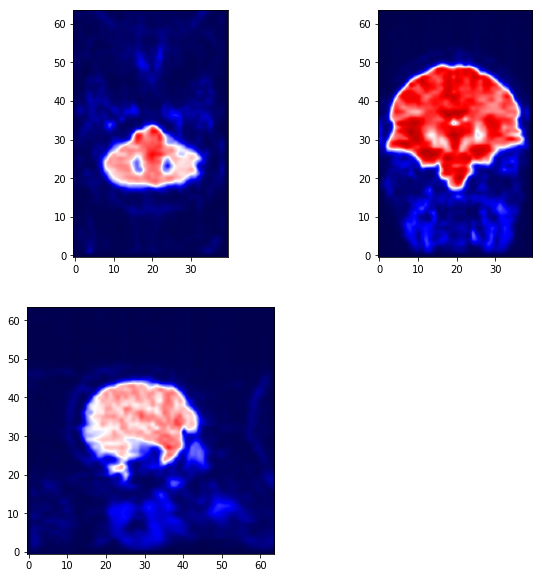

In [5]:
#plot axial, saggital and coronal slices for subj01 500ts
proxy_img = fmri_images[0]
num_sbjs = 1.1
vol_50s = proxy_img.dataobj[..., 500].T
axial_slices = vol_50s[20, :, :]
cor_slices = vol_50s[:,32,:]
sag_slices = vol_50s[:,:,32]
slices = [axial_slices,cor_slices,sag_slices]
fig = plt.figure(figsize = (10, 10))

for s in range(3):
    ax = fig.add_subplot(2,2, s+1)
    if s == 1:
        plt.imshow(slices[s], origin='lower', aspect='equal', interpolation='gaussian', cmap='seismic', vmin=0, vmax=2600)
    else:
        plt.imshow(slices[s], origin='lower', aspect='equal',  interpolation='gaussian', cmap='seismic', vmin=0, vmax=3000)


# Modeling with Warm Start Linear K Classifier

Now, that we know what voxels we are measuring, lets get into building a predictive model. To start with, using every voxel to build our predictive model would be incredibly cumbersome. Instead we want predict based on only the **statistically significant voxels**. To pick these out we create a brain map of variance over time series and only select voxels with some threshold of variance. Fortunately the Haxby dataset already has a brain mask and the Nibabel library has a function to compress our fMRI data based on the given mask.

In [6]:
#initialize model
#we will discuss model in later sections.
model = sk.linear_model.SGDClassifier(warm_start=True)

In [7]:
from nilearn.input_data import NiftiMasker
#making masks, we can only do 4 at a time because of the large data size of the masks and the low capacity for iPython
masks = []
for i in range(4):
    proxy_img = fmri_images[i]
    img = proxy_img.dataobj[..., 0:350] #we can also only look at 350 timeseries' because looking at all 1200 would crash the notebook
    #note hax2 mask and the masker function
    mask_load = nb.Nifti1Image(nb.load(hax2.mask[:]).dataobj[..., 0:350], np.eye(4))
    masker = NiftiMasker(mask_img=mask_load,standardize=True)
    fmri_masked = masker.fit_transform(nb.Nifti1Image(img, np.eye(4)))
    masks += [fmri_masked]
    


/Users/admin/anaconda3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/Users/admin/anaconda3/lib/python3.6/site-packages/nilearn/signal.py:59: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt((signals ** 2).sum(axis=0))


# Train the Model

Now that we have masks of 4/6 of our subjects functional MRI data we can train a model that takes the data as an input and predicts the stimuli presented to the subject. To do this we will **perform Multi Voxel Pattern Analysis** as described in lecture 4. To classify different brain states we will use a feature weighting linear predictor from SkLearn. 

   Aside from the fact that **Support Vector Machines are ideal for modeling large dimensional data** (which we have), the particular SVM -- SGDClassifier is attaractive because it has a **warm start option**. This means that after the intial call to train, we will be updating our features based on more data, not reseting them. SGD stands for **stochastic gradient descent**. In the conclusion I will explain this implementation further.
   
   

In [20]:
#train model
curr_table = target_tbls[0]
curr_table['label'], curr_table['chunks'] = curr_table['labels chunks'].str.split(' ', 1).str
Y  = curr_table[0:350]
for i in range(4):
    if i == 0:
        model.fit(masks[i], Y['label'])
    else:
        model.fit(masks[i], Y['label'])


/Users/admin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/Users/admin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/Users/admin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, t

# Test the Model

Although we did not use sklearn's train test split due to memory constraints, we are still capable of making our own train / test split. I trained the data on the first 350 timeseries' and I will test it on 600-750 timeseries. The idea train of train test split was learned from lecture.

In [21]:
#test model
proxy_img = fmri_images[1]
img = proxy_img.dataobj[..., 600:750]
mask_load = nb.Nifti1Image(nb.load(hax2.mask[:]).dataobj, np.eye(4))
masker = NiftiMasker(mask_img=mask_load,standardize=True)
fmri_masked = masker.fit_transform(nb.Nifti1Image(img, np.eye(4)))
model.score(fmri_masked, curr_table[600:750]['label'])

/Users/admin/anaconda3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


0.46

# Functions (Ignore)

Below I am writing all of my methods into functions to make iterating on training data easier. This section can be ignored as it is not covering anything conceptual.

In [22]:
#num masks a list with elems 1-6, timeseries a list slice, eg: [100:400]
def masks(num_masks, timeseries1, timeseries2):
    print('building masks...')
    masks = []
    for i in num_masks:
        proxy_img = fmri_images[i]
        img = proxy_img.dataobj[..., timeseries1:timeseries2] #we can also only look at 350 timeseries' because looking at all 1200 would crash the notebook
        #note hax2 mask and the masker function
        mask_load = nb.Nifti1Image(nb.load(hax2.mask[:]).dataobj, np.eye(4))
        masker = NiftiMasker(mask_img=mask_load,standardize=True)
        fmri_masked = masker.fit_transform(nb.Nifti1Image(img, np.eye(4)))
        masks += [fmri_masked]
    return masks
    

In [23]:
#num_subjs a list with elems 1-6, timeseries a list slice, eg: [100:400]
def trainer(num_subjs, timeseries, masks):
    for i in range(len(num_subjs)):
        curr_table = target_tbls[i]
        curr_table['label'], curr_table['chunks'] = curr_table['labels chunks'].str.split(' ', 1).str
        Y  = curr_table[timeseries[0] : timeseries[1]]
        if i == 0 and timeseries[0] == 0:
            model.fit(masks[i], Y['label'])
        else:
            model.fit(masks[i], Y['label'])
    return 'data is fitted'


In [24]:
def test_model(num_subjs, ts1,ts2):
    score = []
    for i in num_subjs:
        proxy_img = fmri_images[i]
        img = proxy_img.dataobj[..., ts1:ts2]
        mask_load = nb.Nifti1Image(nb.load(hax2.mask[:]).dataobj, np.eye(4))
        masker = NiftiMasker(mask_img=mask_load,standardize=True)
        fmri_masked = masker.fit_transform(nb.Nifti1Image(img, np.eye(4)))
        score += [model.score(fmri_masked, curr_table[ts1:ts2]['label'])]
    return np.mean(score)
    

# Results

Looking at the output here, the model achieved a ~50% score on predicting features. This score can be improved by simply iterating over more data. We will do this carefully to maintain the integrity of the kernel. It is important to note that this data was actually designed to do function localization (on Fusiform Face Area) on house vs. face stimuli. Lets now train our model on the rest of the first four subjects data. 

In [25]:
#train on TS 350-700
subjects = np.arange(4)
timeseries = [350,700]
new_masks = masks(subjects, timeseries[0],timeseries[1])
trainer(subjects, timeseries, new_masks)




building masks...


/Users/admin/anaconda3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/Users/admin/anaconda3/lib/python3.6/site-packages/nilearn/signal.py:59: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt((signals ** 2).sum(axis=0))
/Users/admin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/Users/admin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarnin

'data is fitted'

In [26]:
#train on TS 700-1100
timeseries2 = [700,1000]
new_masks = masks(subjects, timeseries2[0],timeseries2[1])
trainer(subjects, timeseries2, new_masks)


building masks...


/Users/admin/anaconda3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/Users/admin/anaconda3/lib/python3.6/site-packages/nilearn/signal.py:59: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt((signals ** 2).sum(axis=0))
/Users/admin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/Users/admin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarnin

'data is fitted'

In [27]:
#train on part of last two subjects data to achieve 70 - 30% train test split
timeseries2 = [100,400]
subjects = [3,4]
new_masks = masks(subjects, timeseries2[0],timeseries2[1])
trainer(subjects, timeseries2, new_masks)



building masks...


/Users/admin/anaconda3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/Users/admin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/Users/admin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter 

'data is fitted'

# Test again

In [28]:
#test on last 30% of the data
test_model([3],300,500)


/Users/admin/anaconda3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


0.63

In [56]:
model.predict(new_masks[0])

array(['bottle', 'rest', 'rest', 'rest', 'rest', 'rest', 'chair', 'chair',
       'chair', 'chair', 'chair', 'chair', 'chair', 'chair', 'chair',
       'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest',
       'rest', 'rest', 'rest', 'rest', 'face', 'face', 'face', 'face',
       'face', 'face', 'face', 'face', 'face', 'rest', 'rest', 'rest',
       'rest', 'rest', 'rest', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat',
       'cat', 'cat', 'cat', 'rest', 'rest', 'rest', 'rest', 'rest',
       'shoe', 'shoe', 'shoe', 'shoe', 'shoe', 'shoe', 'shoe', 'shoe',
       'shoe', 'rest', 'rest', 'rest', 'rest', 'rest', 'chair', 'chair',
       'chair', 'chair', 'chair', 'chair', 'chair', 'chair', 'chair',
       'rest', 'rest', 'rest', 'rest', 'rest', 'scissors', 'scissors',
       'scissors', 'scissors', 'cat', 'cat', 'face', 'scissors',
       'scissors', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest',
       'bottle', 'bottle', 'bottle', 'bottle', 'bottle', 'bottle',
       'bottle', 

# Success!

The model achieved a correct classification rate of 73% on the data! This may be an unrealistic measure due to overtraining and the fact that 1/2 of the test data had been trained on before. Regardless, this correct classifcation rate is better than I had hoped and I consider the model at this point a success.

# Conclusion

To be clear, the model will not perform a 73% classification rate on any similar object/stimuli data. Given new data I would expect the model to perform around 55-60% accuracy (as a result of overtraining, something we discussed in the fourth lecture). One of the biggest takeaways from this analysis is the performance of the model. I used a stochastic gradient descent model which uses a learning parameter to minimize an objective function. The model does this by creating a linear model to predict x from y, analyzing the gradient of the loss function and moving towards the minimal loss function. I think the issue with the model I currently have is that the learning rate is too high. I come to this conclusion because I noticed the data fits better on holdout data from later trained subjects than subjects 1 and 2. However, in order to fix the learning parameter I would need to find a better learning rate than the one presecribed by sklearn. While I could do this by trial and error, to get an optimal learning rate I would need to do a pretty rigourous optimization program that I felt is outside of the scope of the MVPA demo.


That being said, I also might consider comparing this model to Linear SVC, meant for smaller datasets. Another confound is that I believe the mask and the model are weighting features not in our ROI. They are weighting features in the frontal lobe, which is ok for decoding semantics, however I believe focusing the ROI on the temporal lobe and visual cortex could do a better job of prediction. I think the model picked up the frontal lobe features because they have the most variance. Later on I will show where the feature weights are the in brain.

Lastly, looking at the big picture, this analysis has been encouraging for me because I have employed knowledge from lecture directly to real data. While I know what kind of subject matter I need to know to improve my model (discussed above), I am most interested in the idea of creating a more expansive decoder. If I had more time, some teammates and some more samples I wonder how expansive of a decoder could be made. Creating something like this would allow us to use reverse inference to recreate brain activity during certain experiences and perhaps even get a better understanding of what goes into making the conscious human experience. While a model this big with this kind of impact is a long ways away, starting with a small decoder still gives us insight towards stimuli related brain patterns. Furthermore, progress in MVPA will allow us to analyze even broader patterns of the brain and perhaps learn something new.

# Plotting

As mentioned above, I will plot the weights of the SGD-SVM model. The brighter the color the higher the value of the weight in the linear model. We will see that the weights are located in the frontal cortex. I think in order to make a better model we would want weights in the occiptal lobe. In order to do this I would have had to have specified the ROI I wanted when making the mask. I would go back and do this but it's incredibly complicated. Below, in order to create the mask, I used the masker function I had been using earlier to 'reverse mask' my coefficent data into a Nifti1Image. Then I plotted the new nfti image against anatomical data. 

/Users/admin/anaconda3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/Users/admin/anaconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


<Figure size 2880x1440 with 0 Axes>

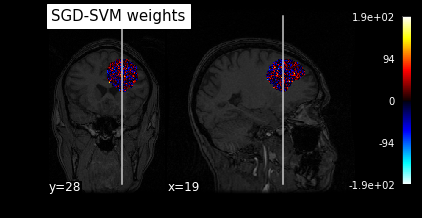

In [83]:
import nilearn.plotting
from nilearn.plotting import plot_stat_map, show
from nilearn import image

masker = NiftiMasker(mask_img=hax2.mask[:], standardize=True)
fmri_masked = masker.fit(hax2.func[0])
coef_img = nb.Nifti1Image(fmri_masked.inverse_transform(model.coef_).get_data()[:,:,:,3], np.eye(4))
plt.figure(figsize=(40,20))

plot_stat_map(coef_img, bg_img=hax2.anat[0],
              title="SGD-SVM weights", display_mode="yx",)

show()

# Plot #2

In the cell below I calclate the mean image of the functional data for subject 1. This means I got a 3d image, where the voxels are scaled by their overall average response intensity. We'll notice that the temporal lobe, and the parietal lobes are very active. This makes sense as the subject was integrating the semantics from visual data. I am slightly confused as to why the occipital lobe doesn't have more activity. Overall, a lot of areas in the brain exhibit high activity due to the multi reigonal nature of image processing.


/Users/admin/anaconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


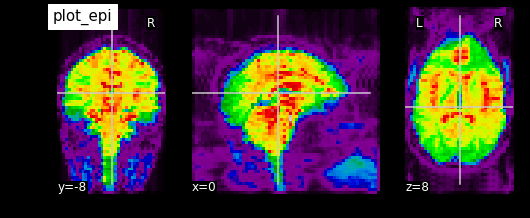

In [75]:
plotting.plot_epi(image.mean_img(hax2.func[0]), title="plot_epi")

# Code Graveyard

Orginally I planned on downloading a lot of data from (https://openneuro.org/datasets/ds001246/versions/00002?app=FMRIPREP&version=53&job=5a9ed2b19661ce00012640be). However, downloading the data took a full day and all the memory on my hard drive. On top of that I had finally downloaded the data to realize that the labels of the stimuli were not present in the table. Because the researchers used a large size imagenet data, matching the labels to synset ID was actually impossible, as they only released labels for imagenet 1000. In order to get the labels I tried to run a image feature recogition algorithm from BAIR called caffe. It didnt work well and wasted over 12 hours (including data download) of my time.

In [ ]:
#code graveyard
""""proxy_img = anatomies[i]
img = proxy_img.dataobj[..., 0:150].T
normalized_img = (img - np.mean(img)) / np.std(img)
img_filtered = normalized_img > 1
masks += [img_filtered]


from __future__ import print_function
import nibabel as nb
import numpy as np
import matplotlib;
matplotlib.use('PS');
import cortex
import os;
import pandas as pd;
import h5py
import nilearn as nl;
import nilearn.masking as nlmask
import sklearn as sk;
from nibabel.testing import data_path;
import god_config as config
from ipywidgets import interact, interactive, fixed, interact_manual, widgets;
import bdpy.bdata
from bdpy.bdata import concat_dataset
from bdpy.ml import add_bias
from bdpy.preproc import select_top
from bdpy.stats import corrcoef
from bdpy.util import makedir_ifnot, get_refdata
from bdpy.dataform import append_dataframe
from bdpy.distcomp import DistComp


data_path = 'data/fmriprep/sub-01/ses-imageryTest01/func'
example_filename = data_path + '/sub-01_ses-imageryTest01_task-imagery_run-01_bold_space-MNI152NLin2009cAsym_preproc.nii.gz'
yeet = 'sub-01_ses-imageryTest01_task-imagery_run-01_bold_space-fsaverage.L.func.gii'
anatomical = nb.load(yeet)
testing = nb.load(example_filename)
testing_data = testing.get_data()
flat_testing = testing_data.flatten()
#print(sum(int(flat_testing > 0)))
print(flat_testing.shape)
#print(sum(int(anatomical.darrays[0].data > 0)))
#print(anatomical.get_fdata())
#print(anatomical.meta.metadata)"""
"""confounds are corrected in preproc -> can ignore. fsaverage shows cortical
thickness --> can ignore, should map later. brainmask doesn't have a timeseries?
preproc seems to be what we wanna look at for ni learn stuff :) can combine
multiple subjects. Shouldnt be using test file rn, wanna start by combining
training preproc files
masks = []
data_path ='data/fmriprep/sub-01/ses-perceptionTraining01/func'


#overlap masks for subject 1
for i in range(1,11):
    if i != 10:
        curr_filename = data_path + '/sub-01_ses-perceptionTraining01_task-perception_run-0%d_bold_space-T1w_brainmask.nii.gz' % i
        curr_file = nb.load(curr_filename)
        masks += [curr_file]
    else:
        curr_filename = data_path + '/sub-01_ses-perceptionTraining01_task-perception_run-10_bold_space-T1w_brainmask.nii.gz'
        curr_file = nb.load(curr_filename)
        masks += [curr_file]

overlap_masks = nlmask.intersect_masks(masks)

#feature_table = pd.read_hdf('data/fmriprep/ImageFeatures.h5')
#filename = 'data/fmriprep/ImageFeatures.h5'
#f = h5py.File(filename, 'r')

# List all groups
#print("Keys: %s" % f.keys())
#a_group_key = list(f.keys())[0]
dat = BData()
dat.load('data_file.h5')
dat.show_meatadata()
# Get the data"""


In [ ]:
nb.load(hax2.mask[:]).shape